In [2]:
import pandas as pd


In [3]:
health_df = pd.read_csv("data/interim/health.csv")
health_df = health_df[health_df["status"] != "TERMINATED"]
health_df.shape


(3465, 26)

In [4]:
# Extract metadata
abstracts = health_df["objective"].to_numpy()
titles = health_df["title"].to_numpy()


In [5]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer("NovaSearch/stella_en_400M_v5", trust_remote_code=True)
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)


Some weights of the model checkpoint at NovaSearch/stella_en_400M_v5 were not used when initializing NewModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/109 [00:00<?, ?it/s]

In [6]:
embeddings.shape


(3465, 1024)

In [29]:
from umap import UMAP

# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(
    n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42
    )
reduced_embeddings = umap_model.fit_transform(embeddings)


In [75]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=20,
    metric="euclidean",
    cluster_selection_method="eom",
    min_samples=15,
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))


36

In [70]:
import numpy as np
# Print first three documents in cluster 0
cluster = 0

for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")
    

Chronic kidney disease is a major cause of morbidity and mortality in the EU. About 10-15% of the EU population has chronic kidney disease (CKD) and this number is expected to increase in the future decades.   Diabetes is today the main cause of CKD in the EU: about, 30% of the cases with dialysis t... 

Chronic Kidney Disease (CKD) is one of the major causes of death in high income countries and its prevalence is growing rapidly. New therapies for the treatment of CKD have shown clear efficacy at a population level. Yet, individual patients respond differently with many patients showing suboptimal ... 

Hypertension (HTN) is a leading cause of cardiovascular disease (CVD), affecting >80 million EU citizens and >50% of people aged >65 years, resulting in 1 million deaths per year, predominantly from CVD and chronic kidney disease (CKD). The damage done by CVD costs almost 300 billion annually in the... 



/storage/projects/climate_llm/Modern-Analytics/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/storage/projects/climate_llm/Modern-Analytics/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(2494, 4)
(971, 4)


(np.float64(3.638433575630188),
 np.float64(12.471729636192322),
 np.float64(1.5548464417457581),
 np.float64(10.685571277141571))

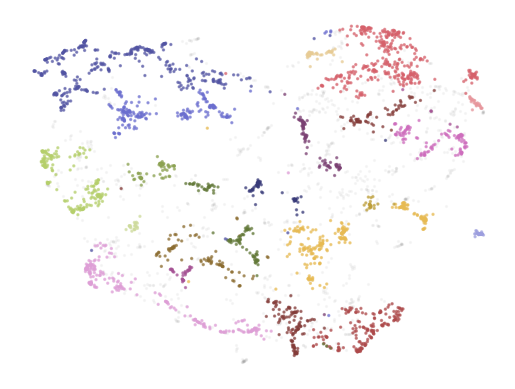

In [ ]:
# Check clusters
# import pandas as pd
# import matplotlib.pyplot as plt

# Reduce 384-dimensional embeddings to two dimensions for easier visualization
# reduced_embeddings = UMAP(
#     n_components=2, min_dist=0.0, metric="cosine", random_state=42
# ).fit_transform(embeddings)

# Create dataframe
# df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
# df["title"] = titles
# df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
# to_plot = df.loc[df.cluster != "-1", :]
# outliers = df.loc[df.cluster == "-1", :]

# print(to_plot.shape)
# print(outliers.shape)

# Plot outliers and non-outliers separately
# plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey")
# plt.scatter(to_plot.x, to_plot.y, c=to_plot.cluster.astype(int),
            # alpha=0.6, s=2, cmap="tab20b"
# )
# plt.axis("off")


In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stopwords = list(stopwords.words("english")) + ["project", "health", "research", "medical"]
vectorizer_model = CountVectorizer(stop_words=stopwords, min_df=2, ngram_range=(1, 2))


In [76]:
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
# from spacy.cli import download

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
# download("en_core_web_sm")
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.2)

# Flan-t5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
# Update our topic representations using Flan-T5
generator = pipeline("text2text-generation", model="google/flan-t5-small")
flant5_model = TextGeneration(
    generator, prompt=prompt, doc_length=350, tokenizer="whitespace"
)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "POS": pos_model,
    "MMR": mmr_model,
    # "Flan-t5": flant5_model,
}


Device set to use cuda:0


In [89]:
from bertopic import BERTopic

# Train our model with our previously defined models
# topic_model = BERTopic(
#     embedding_model=embedding_model,
#     umap_model=umap_model,
#     hdbscan_model=hdbscan_model,
#     verbose=True
# ).fit(abstracts, embeddings)

topic_model = BERTopic(
  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=8,
  verbose=True,
  language="english"
)

topics, probs = topic_model.fit_transform(abstracts, embeddings)


2025-05-25 00:38:23,774 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-25 00:38:43,385 - BERTopic - Dimensionality - Completed ✓
2025-05-25 00:38:43,389 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-25 00:38:43,457 - BERTopic - Cluster - Completed ✓
2025-05-25 00:38:43,461 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-25 00:39:11,466 - BERTopic - Representation - Completed ✓


In [78]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,KeyBERT,POS,MMR,Representative_Docs
0,-1,967,-1_new_cell_data_based,"[new, cell, data, based, development, cancer, ...","[mechanisms, approaches, dna, aims, innovation...","[new, cell, data, development, cancer, human, ...","[new, cell, data, cancer, cells, develop, drug...",[Non-Communicable Diseases (NCDs) e.g. osteopo...
1,0,303,0_cancer_cells_tumor_cell,"[cancer, cells, tumor, cell, immune, tumour, t...","[immunotherapies, immunotherapy, tumor microen...","[cancer, cells, tumor, cell, immune, tumour, t...","[cancer, cells, tumor, immune, tumour, tumors,...",[Immunotherapies have revolutionized the treat...
2,1,210,1_cancer_imaging_patients_clinical,"[cancer, imaging, patients, clinical, patient,...","[cancer patients, breast cancer, cancer, oncol...","[cancer, imaging, patients, clinical, patient,...","[cancer, imaging, clinical, breast, ai, detect...","[Prostate cancer (PCa), is a type of cancer wi..."
3,2,174,2_ad_brain_disease_neurodegenerative,"[ad, brain, disease, neurodegenerative, pd, pr...","[microglia, neuroinflammation, neurodegenerati...","[brain, disease, neurodegenerative, protein, n...","[neurodegenerative, neuronal, microglia, alzhe...",[The recently approved drugs for Alzheimers di...
4,3,168,3_heart_cardiac_patients_risk,"[heart, cardiac, patients, risk, stroke, cardi...","[cardiomyocytes, myocardial, cardiac, cardiova...","[heart, cardiac, patients, risk, stroke, cardi...","[heart, cardiac, stroke, cardiovascular, clini...",[Cardiovascular diseases (CVDs) are the leadin...
5,4,115,4_brain_epilepsy_stimulation_neural,"[brain, epilepsy, stimulation, neural, motor, ...","[neuromodulation, electrical stimulation, eeg,...","[brain, epilepsy, stimulation, neural, motor, ...","[brain, epilepsy, stimulation, neural, neurolo...",[Many individuals suffer partial or complete m...
6,5,114,5_food_sustainable_production_aquaculture,"[food, sustainable, production, aquaculture, p...","[food systems, food system, sustainable food, ...","[food, sustainable, production, aquaculture, p...","[food, sustainable, aquaculture, food system, ...","[The global food system, responsible for up to..."
7,6,108,6_antibiotics_resistance_bacteria_bacterial,"[antibiotics, resistance, bacteria, bacterial,...","[antimicrobial resistance, antibiotic resistan...","[antibiotics, resistance, bacteria, bacterial,...","[antibiotics, bacterial, antimicrobial, antibi...",[The emergence of Gram-negative bacterial resi...
8,7,98,7_malaria_africa_tb_vaccine,"[malaria, africa, tb, vaccine, clinical, paras...","[malaria, falciparum, plasmodium, vaccines, va...","[malaria, vaccine, clinical, parasite, childre...","[malaria, africa, tb, plasmodium, parasites, v...",[Malaria killed about 640 thousand people in 2...
9,8,93,8_gut_ibd_microbiome_microbiota,"[gut, ibd, microbiome, microbiota, intestinal,...","[gut microbiome, gut microbiota, microbiome, m...","[gut, microbiome, microbiota, intestinal, host...","[gut, ibd, microbiome, microbiota, intestinal,...","[The human gut microbiota, the trillions of mi..."


In [93]:
topic_model.visualize_barchart(top_n_topics=34, n_words=5)


In [90]:
# Reduce outliers using the `probabilities` strategy
new_topics = topic_model.reduce_outliers(
    abstracts, topics, probabilities=probs, strategy="distributions"
)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


In [91]:
topic_model.update_topics(abstracts, topics=new_topics)


2025-05-25 00:41:29,483 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [92]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,POS,MMR,Representative_Docs
0,0,402,0_cancer_of_cells_to,"[cancer, of, cells, to, the, cell, in, and, tu...","[immunotherapies, immunotherapy, tumor microen...","[cancer, cells, tumor, cell, immune, tumour, t...","[cancer, cells, tumor, immune, tumour, tumors,...",[Immunotherapies have revolutionized the treat...
1,1,356,1_the_and_of_cancer,"[the, and, of, cancer, to, in, for, is, will, ...","[cancer patients, breast cancer, cancer, oncol...","[cancer, imaging, patients, clinical, patient,...","[cancer, imaging, clinical, breast, ai, detect...","[Prostate cancer (PCa), is a type of cancer wi..."
2,2,223,2_ad_the_of_in,"[ad, the, of, in, and, brain, to, disease, is,...","[microglia, neuroinflammation, neurodegenerati...","[brain, disease, neurodegenerative, protein, n...","[neurodegenerative, neuronal, microglia, alzhe...",[The recently approved drugs for Alzheimers di...
3,3,209,3_the_heart_and_of,"[the, heart, and, of, to, cardiac, in, for, is...","[cardiomyocytes, myocardial, cardiac, cardiova...","[heart, cardiac, patients, risk, stroke, cardi...","[heart, cardiac, stroke, cardiovascular, clini...",[Cardiovascular diseases (CVDs) are the leadin...
4,4,144,4_brain_the_and_of,"[brain, the, and, of, to, stimulation, epileps...","[neuromodulation, electrical stimulation, eeg,...","[brain, epilepsy, stimulation, neural, motor, ...","[brain, epilepsy, stimulation, neural, neurolo...",[Many individuals suffer partial or complete m...
5,5,153,5_food_and_the_of,"[food, and, the, of, to, in, will, sustainable...","[food systems, food system, sustainable food, ...","[food, sustainable, production, aquaculture, p...","[food, sustainable, aquaculture, food system, ...","[The global food system, responsible for up to..."
6,6,125,6_the_of_bacteria_antibiotics,"[the, of, bacteria, antibiotics, resistance, b...","[antimicrobial resistance, antibiotic resistan...","[antibiotics, resistance, bacteria, bacterial,...","[antibiotics, bacterial, antimicrobial, antibi...",[The emergence of Gram-negative bacterial resi...
7,7,121,7_malaria_and_to_the,"[malaria, and, to, the, of, in, africa, tb, fo...","[malaria, falciparum, plasmodium, vaccines, va...","[malaria, vaccine, clinical, parasite, childre...","[malaria, africa, tb, plasmodium, parasites, v...",[Malaria killed about 640 thousand people in 2...
8,8,117,8_gut_the_and_of,"[gut, the, and, of, in, to, microbiota, ibd, m...","[gut microbiome, gut microbiota, microbiome, m...","[gut, microbiome, microbiota, intestinal, host...","[gut, ibd, microbiome, microbiota, intestinal,...","[The human gut microbiota, the trillions of mi..."
9,9,105,9_plant_the_of_and,"[plant, the, of, and, to, plants, in, will, cr...","[arabidopsis, plant, plants, microbiome, roots...","[plant, plants, crop, climate, species, drough...","[plant, plants, crop, species, drought, crops,...","[Agriculture, which underpins the livelihoods ..."


In [ ]:
temp = topic_model.get_topic_info()
temp.to_csv("data/processed/topics.csv")


In [19]:
# To get all representations for a single topic
topic_model.get_topic(8, full=True)


{'Main': [('food', np.float64(0.08473403490676748)),
  ('sustainable', np.float64(0.027949629021064768)),
  ('protein', np.float64(0.018075719982218113)),
  ('production', np.float64(0.01690755088719185)),
  ('food systems', np.float64(0.015579310061626604)),
  ('nutrition', np.float64(0.015227458081535732)),
  ('based', np.float64(0.014701919524318628)),
  ('products', np.float64(0.014508949316945914)),
  ('diets', np.float64(0.014358702139202612)),
  ('plant', np.float64(0.014346323478308724))],
 'KeyBERT': [('food systems', np.float32(0.6771498)),
  ('sustainable food', np.float32(0.63270825)),
  ('food security', np.float32(0.6211364)),
  ('agri food', np.float32(0.588652)),
  ('food safety', np.float32(0.53301615)),
  ('healthy sustainable', np.float32(0.521467)),
  ('foods', np.float32(0.50952613)),
  ('agri', np.float32(0.50917566)),
  ('food', np.float32(0.5028857)),
  ('sustainability', np.float32(0.48213464))],
 'Flan-t5': [('INCiTiS-FOOD', 1),
  ('', 0),
  ('', 0),
  ('', 0)

In [18]:
# or use one of the other topic representations, like KeyBERTInspired
# keybert_topic_labels = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in topic_model.topic_aspects_["KeyBERT"].items()}
# topic_model.set_topic_labels(keybert_topic_labels)

pos_topic_labels = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in topic_model.topic_aspects_["POS"].items()}
topic_model.set_topic_labels(pos_topic_labels)


In [94]:
topic_model.visualize_topics(custom_labels=True)


In [20]:
topic_model.visualize_hierarchy(custom_labels=False)


In [22]:
# `topic_distr` contains the distribution of topics in each document
topic_distr, _ = topic_model.approximate_distribution(abstracts, window=8, stride=4)


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


In [29]:
from pprint import pprint

abstract_id = 10
pprint(abstracts[abstract_id], width=80)


('BiomimX Beating organs-on-chips (OoC) are in vitro miniaturized and living '
 'replica of human organs and diseases,building upon cutting-edge technologies '
 'and human cells. Beating OoC provide a faithful replication of native '
 'humanphysiology integrating miniaturized 3D cell culture techniques, '
 'mechanical stimulation (uBeat®) and electrical recordingcapabilities '
 '(uSense). BiomimX’s proprietary key technology (uBeat®) supports 3D human '
 'cell cultures and integrates acontrolled and tunable mechanical stimulation '
 'system. uBeat® leads to the generation of mature and functional '
 'miniaturizedreplication of human organs adequate to test compounds '
 'toxicity/functionality in a high-throughput fashion. Integration ofuSense '
 'allows real-time evaluation of clinically relevant parameters from the '
 'established beating models. BiomimX’sBeating OoC represent a safer, more '
 'efficient and faster alternative to poorly predictable preclinical models to '
 'date avail

In [24]:
# Visualize the topic-document distribution for a single document
topic_model.visualize_distribution(topic_distr[abstract_id])


In [25]:
# Visualize the topic-document distribution for a single document
topic_model.visualize_distribution(topic_distr[abstract_id], custom_labels=True)


In [ ]:
# Calculate the topic distributions on a token-level
# topic_distr, topic_token_distr = topic_model.approximate_distribution(abstracts, use_embedding_model=True)

# Visualize the token-level distributions
# df = topic_model.visualize_approximate_distribution(abstracts[abstract_id], topic_token_distr[0])
# df


In [42]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(abstracts, topics)

# Reduce outliers with pre-calculate embeddings instead
new_topics = topic_model.reduce_outliers(abstracts, topics, strategy="embeddings", embeddings=embeddings)


100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


In [43]:
topic_model.update_topics(abstracts, topics=new_topics)


2025-05-21 08:41:51,380 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,KeyBERT,Flan-t5,MMR,POS,Representative_Docs
0,0,1077,0_the_of_and_to,"[the, of, and, to, in, cancer, will, for, is, ...","[cancer cells, tumors, metastatic, tumour, can...","[IPSIRIUS, , , , , , , , , ]","[cancer, cells, patients, project, immune, res...","[cancer, cell, cells, tumor, treatment, patien...",[Novel cancer molecular-targeted therapies all...
1,1,378,1_and_the_of_to,"[and, the, of, to, in, will, for, with, is, by]","[sars cov, sars, covid 19, viruses, antiviral,...",[Virus: Virus: Virus: Virus: Virus: Virus: Vir...,"[vaccine, malaria, viruses, immune, vaccines, ...","[viral, virus, vaccine, malaria, viruses, infe...",[Lower respiratory tract infections resulting ...
2,2,204,2_the_of_and_in,"[the, of, and, in, ad, to, brain, disease, wil...","[microglia, neuroinflammation, neurodegenerati...",[human microglia transduce toxicity to neurons...,"[dementia, microglia, neurodegenerative, alzhe...","[disease, brain, dementia, protein, neurodegen...",[The recently approved drugs for Alzheimers di...
3,3,189,3_the_and_of_to,"[the, and, of, to, in, heart, cardiac, for, is...","[cardiomyocytes, myocardial, cardiac, cardiova...","[novel bioprinting for cardiac fibrosis, , , ,...","[heart, cardiac, patients, cardiovascular, str...","[heart, cardiac, patients, clinical, cardiovas...",[Cardiovascular diseases (CVDs) are the leadin...
4,4,195,4_and_the_of_to,"[and, the, of, to, in, on, social, health, wil...","[eu, europe, european, crises, 19 pandemic, pa...","[REGROUP: resiliency, , , , , , , , , ]","[social, project, research, policy, covid, wom...","[social, political, health, pandemic, project,...",[RECOVER-GEU presents an innovative gendered p...
5,5,135,5_the_of_and_to,"[the, of, and, to, in, resistance, antibiotics...","[antimicrobial resistance, antibiotic resistan...","[Antimicrobial resistance, , , , , , , , , ]","[antibiotics, antibiotic, antimicrobial, bacte...","[antibiotics, resistance, antibiotic, antimicr...",[The emergence of Gram-negative bacterial resi...
6,6,187,6_the_and_of_to,"[the, and, of, to, in, for, bone, is, will, with]","[bone regeneration, bioprinting, tissue engine...","[BioForceInk: bioactive reinforcing bioink, , ...","[bone, tissue, oa, implants, bioprinting, cart...","[bone, tissue, pain, mechanical, implants, bio...",[Bone fracture nonunion (FNU) is one of the le...
7,7,113,7_gut_the_and_of,"[gut, the, and, of, in, to, microbiome, ibd, w...","[gut microbiome, gut microbiota, microbiome, m...","[Inflammatory Bowel Disease, , , , , , , , , ]","[gut, ibd, microbiota, intestinal, microbiome,...","[gut, microbiota, intestinal, microbiome, host...","[The human gut microbiota, the trillions of mi..."
8,8,139,8_food_and_the_of,"[food, and, the, of, to, in, will, for, sustai...","[food systems, sustainable food, food security...","[INCiTiS-FOOD, , , , , , , , , ]","[food, sustainable, protein, food systems, nut...","[food, sustainable, protein, production, nutri...",[The agri-food industry faces numerous challen...
9,9,146,9_the_of_and_to,"[the, of, and, to, in, will, brain, for, this,...","[cortex, neural, neurons, neuronal, neuroscien...","[psychiatric, , , , , , , , , ]","[brain, neural, psychiatric, cognitive, anxiet...","[brain, neural, disorders, visual, sensory, ac...",[An organism’s survival depends on accurately ...


In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))


In [ ]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()


In [ ]:
# Visualize relationships between topics
# topic_model.visualize_heatmap(n_clusters=30)


In [ ]:
# Visualize the potential hierarchical structure of topics
# topic_model.visualize_hierarchy()


In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(30)),
    reduced_embeddings=reduced_embeddings,
    width=1200
)
fig
